# 1. Install & Import 라이브러리

In [8]:
!pip3 install selenium webdriver_manager pandas numpy konlpy tensorflow

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import pandas as pd
import numpy as np
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datetime import datetime, timedelta


# 2. 경로 설정

In [9]:
PATH_POST_DATA_CSV = 'data_csv/post.csv'
PATH_MATCH_STAT_CSV = 'data_csv/match_stats.csv'
PATH_PLAYERS_TXT = 'data_txt/players.txt'
PATH_MATCH_INFO_PNG = 'data_match_info'

# 3. 함수 설정

In [10]:
def reading_file(file_path):
    encodings = ['cp949', 'utf-8', 'ISO-8859-1', 'cp1252']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            return df
        except: pass
    return None

stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
okt = Okt()
clean_train_review = []
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
  review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)
  word_review = okt.morphs(review_text,stem=True)
  if remove_stopwords:
    word_review = [token for token in word_review if not token in stop_words]
  return word_review


# 3. 저장된 데이터 수집

### 3.1. 선수 정보 불러오기

In [11]:
# 선수이름이 저장된 TXT파일 불러오기
player_box = set()
with open(PATH_PLAYERS_TXT, 'r', encoding='utf-8') as f:
    for p in f.readlines():
        player_box.add(p.strip())

# 불러온 선수 명단 출력
for i, player in enumerate(player_box):
    print(player, end = ' ')
    if (i+1)%10==0:
        print()

이용 홍현석 강성진 정승현 남태희 황의조 박진섭 고승범 오현규 박규현 
손흥민 주민규 윤종규 이명재 손준호 고영준 조현우 조유민 권경원 이기제 
이상민 문선민 이재익 안현범 김동현 엄원상 김영권 김준홍 조규성 이재성 
강상우 양현준 홍철 이동경 조영욱 김승규 김문환 박용우 김태환 권창훈 
황인범 이동준 이영재 김진규 원두재 이창근 구성윤 김동준 이순민 이강인 
정호연 송민규 백승호 김주성 김민재 송범근 이기혁 박민규 황희찬 박지수 
나상호 정우영 김진수 김지수 설영우 

### 3.2. 게시글 파일 불러오기

In [ ]:
df_post = reading_file(PATH_POST_DATA_CSV)
df_post

### 3.3. 매치 정보 불러오기

In [ ]:
df_match = reading_file(PATH_MATCH_STAT_CSV)
df_match

### 3.4. 경기 시간 기준, 36시간 이내 선수이름 언급 빈도

In [12]:
# 게시글 기록 시간 범위
begin = df_post['DATE_TIME'].min()
end = df_post['DATE_TIME'].max()

# 빈도 계산
match_post = []
for i in range(len(df_match)):
    # 진행률
    progress = f'{100*(i+1)/len(df_match):.2f}'
    print(f'\r{progress}%, {i+1}/{len(df_match)}', end='')

    # 매치 정보
    match_info = df_match.iloc[i]
    match_time = match_info['DATE_TIME']

    # 집계
    if begin <= match_time <= end: # 범위 내의 데이터 한정
        # 경기시간 기준 36시간 이내 게시글 수집
        time_value = datetime.strptime(match_time, '%Y-%m-%d %H:%M:%S')
        match_time_later = str(time_value + timedelta(hours=36))
        indexes = df_post[(df_post['DATE_TIME'] >= match_time) & (df_post['DATE_TIME'] < match_time_later)].index

        # 빈도 계산   
        if len(indexes) > 0:
            frequency = {}
            for index in indexes:
                post = df_post['POST'][index]
                for word in preprocessing(post ,okt,remove_stopwords=True,stop_words= stop_words):
                    if not word in player_box:
                        continue
                    if not word in frequency:
                        frequency[word] = 1
                    frequency[word] += 1
            sorted_frequency = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

            match_post.append([match_info, sorted_frequency])


100.00%, 66/66

# 4. 그래프 출력 -> data_match_info 로 저장

'explode' must be of length 'x'
'explode' must be of length 'x'


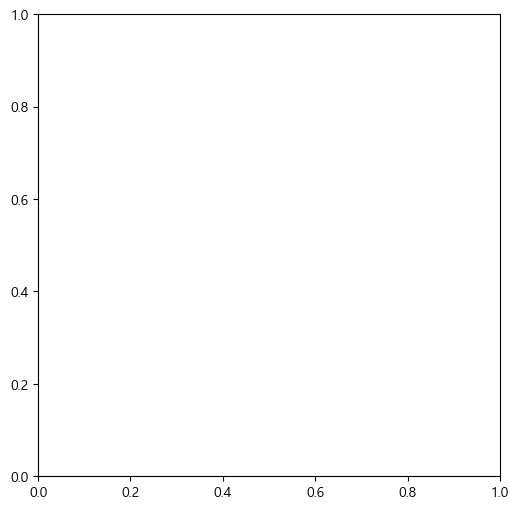

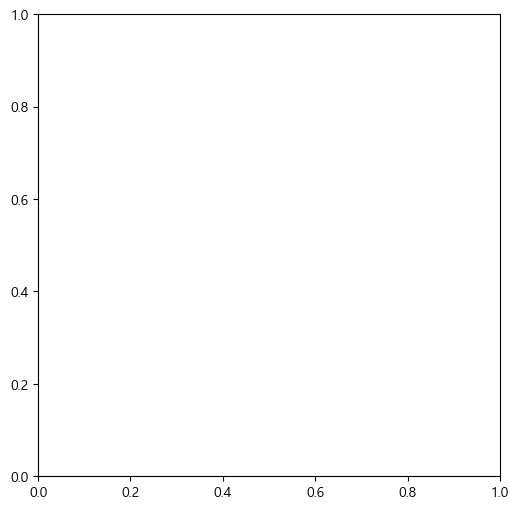

In [16]:
import matplotlib.pyplot as plt

# 한글 폰트 및 마이너스 기호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def frequency_graph(index, match_post):
    try:
        match_info, frequency = match_post[index]
        top_5 = frequency[:5]
        players, scores = zip(*top_5)

        # 그래프 설정
        plt.figure(figsize=(10, 6))  # 그래프와 텍스트 정보를 위한 공간 확보
        explode = (0.1, 0, 0, 0, 0)
        colors = plt.get_cmap('Pastel1')(np.linspace(0.2, 0.7, len(top_5)))
        
        # 파이 차트 그리기
        plt.pie(scores, labels=players, autopct='%1.1f%%', startangle=140, explode=explode, shadow=True, colors=colors)
        plt.title('Top 5 Players Frequency')
        
        # match_info 정보를 텍스트로 추가
        match_info_str = f"{match_info['DATE_TIME']}\nStadium: {match_info['Stadium']}\nKorea vs. {match_info['Opponent']}\nScore: {match_info['Korea_score']} - {match_info['Oppo_score']}"
        match_info_str = f"{match_info['DATE_TIME']}\nStadium: {match_info['Stadium']}\nKorea vs. {match_info['Opponent']}\nScore: {match_info['Korea_score']} - {match_info['Oppo_score']}"

        plt.annotate(match_info_str, xy=(1, 0), xycoords='axes fraction', fontsize=10, xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')
        
        # 파일 저장
        plt.savefig(f'{PATH_MATCH_INFO_PNG}/match_info_{index}.png', bbox_inches='tight')
        plt.close()  # 현재 그림 닫기
    except Exception as e:
        print(e)

for i in range(len(match_post)):
    frequency_graph(i, match_post)


In [ ]:
import matplotlib.pyplot as plt

# 가장 최근 경기의 선수 언급 빈도 데이터를 예시로 사용
if match_post:
    match_info, frequencies = match_post[-1]  # 가장 최근 경기 데이터
    labels, sizes = zip(*frequencies)  # 라벨과 사이즈 분리

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
